In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from utils import load_run

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

run = load_run('1638012544')
df = run['data']

# Run the fit
df2 = df.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])
print("DataFrame creation done")
comp_or_var = .85
da_pca = PCA(comp_or_var)
da_scaler = StandardScaler()
df2 = da_pca.fit_transform(df2)
print(f"PCA fit+transform done. Keeping {f'{da_pca.n_components_} features' if comp_or_var < 1 else f'{da_pca.explained_variance_ * 100}% variance'}")
df2 = da_scaler.fit_transform(df2)
print("Scaler fit+transform done")
clust.fit(df2)
print("OPTICS clustering done")

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
print("DBSCAN (0.5) clustering done")
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)
print("DBSCAN (2) clustering done")

space = np.arange(len(df2))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = df2[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(df2[clust.labels_ == -1, 0], df2[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = df2[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(df2[labels_050 == -1, 0], df2[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = df2[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(df2[labels_200 == -1, 0], df2[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import extract_first_entries, generate_pixel_columns

file = './dataset/bread.ndjson'
df = extract_first_entries(file, recognized=True)
print('Done loading')
df = generate_pixel_columns(df, 32, 1, True)
print('Done generating pixel columns')
x = df.filter(regex=('pixel.+'))
y = df['countrycode']

# wcss = []
# for i in range(1,11):
#    print(f'Fitting model {i}/10...')
#    model = KMeans(n_clusters = i, init = "k-means++")
#    model.fit(x)
#    wcss.append(model.inertia_)
# plt.figure(figsize=(10,10))
# plt.plot(range(1,11), wcss)
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

Done loading
Done generating pixel columns


In [ ]:
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from IPython.display import display, Image as ipimg
from utils import render_multiple
from sklearn.ensemble import IsolationForest

num_clusters = 2
pca = PCA(2)
data = pca.fit_transform(x)
print('Done transforming data')
# con = kneighbors_graph(data, n_neighbors=10, include_self=False)

outlier_det = IsolationForest(random_state=42)
outliers = outlier_det.fit_predict(data)

clsts = {
    'KMeans': KMeans(n_clusters = num_clusters, init = "k-means++"),
    # 'AgglomerativeAverage': AgglomerativeClustering(
    #     linkage='average',
    #     affinity="cityblock",
    #     n_clusters=num_clusters,
    #     connectivity=con
    # ),
    # 'AgglomerativeWard': AgglomerativeClustering(
    #     linkage='ward',
    #     n_clusters=num_clusters,
    #     connectivity=con
    # ),
    # 'SpectralClustering': SpectralClustering(
    #     n_clusters=num_clusters,
    #     eigen_solver="arpack",
    #     affinity="nearest_neighbors",
    # ),
    'Birch': Birch(n_clusters=num_clusters),
    'Gaussian': GaussianMixture(
        n_components=num_clusters, covariance_type="full"
    )
}

df3 = pd.DataFrame(data)
df3['outlier'] = np.array(map(lambda n: 1 if n < 0 else 0, outliers))
df3['drawing'] = df['drawing']
df3['countrycode'] = y
df3 = df3[df3['outlier'] == 0]
for typ, clst in clsts.items():
    pixels = df3.filter(regex='[01]')
    model = clst.fit_predict(pixels)
    print(f"Done fitting model {typ}")

    plt.figure(figsize=(10,10))
    clusters = np.unique(model)

    for cluster in clusters:
        drawings = df3[model == cluster]['drawing']
        display(ipimg(render_multiple(drawings if len(drawings) < 2000 else drawings.sample(2000))))
        print(f'Entries: {len(drawings)}')
        plt.scatter(df3[model == cluster][0] , df3[model == cluster][1] , label = cluster)
    plt.legend()

    # data2 = pd.DataFrame(data)
    # data2['countrycode'] = y
    # data2['outlier'] = np.array(map(lambda n: 1 if n < 0 else 0, outliers))
    country = df3[df3['countrycode'].isin(['RO', 'BR'])]
    plt.scatter(country[0], country[1], marker='.', color='k')
    # plt.scatter(data2[data2['outlier'] == 1][0], data2[data2['outlier'] == 1][1], c='red')

    plt.show()

Processing ./dataset/bread.ndjson...
Directory "./clustering/bread" already exists.
Done loading
Done generating pixel columns
Done transforming data
Done with outlier detection
Created directory "./clustering/bread/KMeans/
Done fitting model KMeans
Done saving images.
Created directory "./clustering/bread/Birch/
Done fitting model Birch
Done saving images.
Created directory "./clustering/bread/Gaussian/
Done fitting model Gaussian
Done saving images.
Processing ./dataset/power outlet.ndjson...
Directory "./clustering/power-outlet" already exists.
Done loading
Done generating pixel columns
Done transforming data
Done with outlier detection
Created directory "./clustering/power-outlet/KMeans/
Done fitting model KMeans
Done saving images.
Created directory "./clustering/power-outlet/Birch/
Done fitting model Birch
Done saving images.
Created directory "./clustering/power-outlet/Gaussian/
Done fitting model Gaussian
Done saving images.


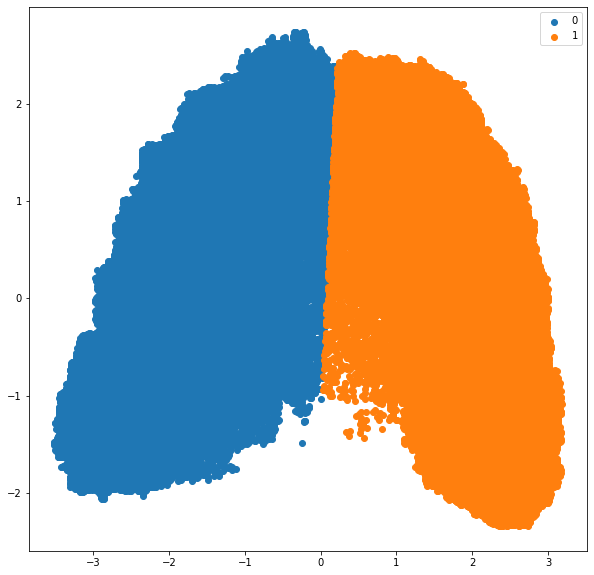

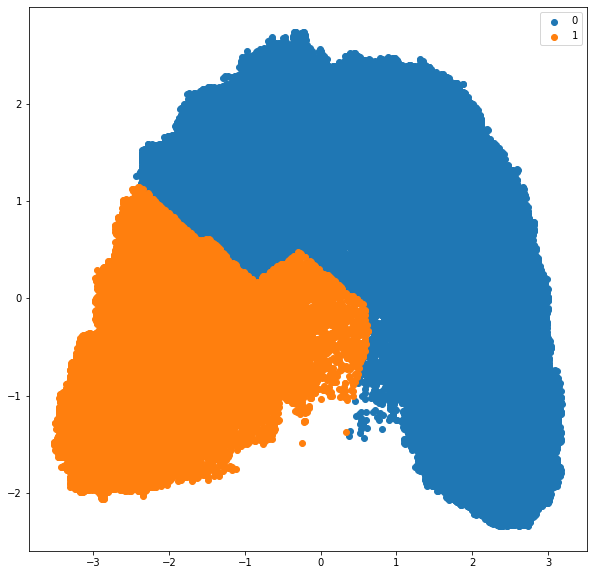

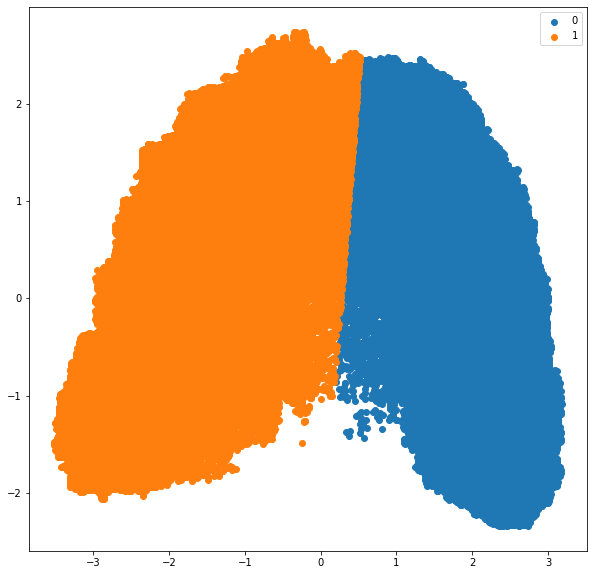

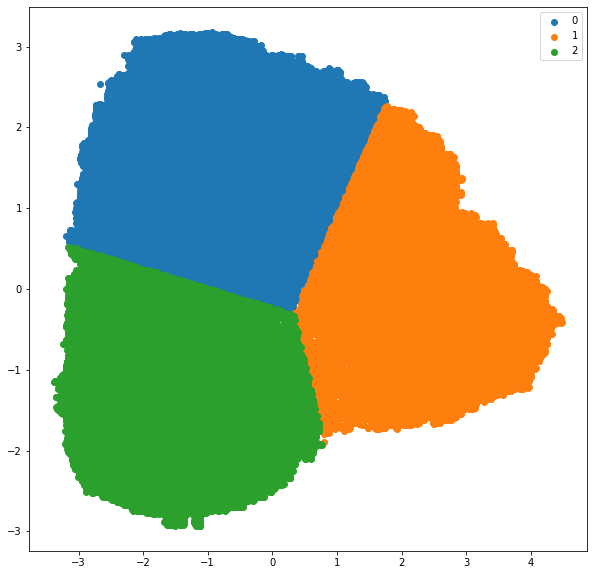

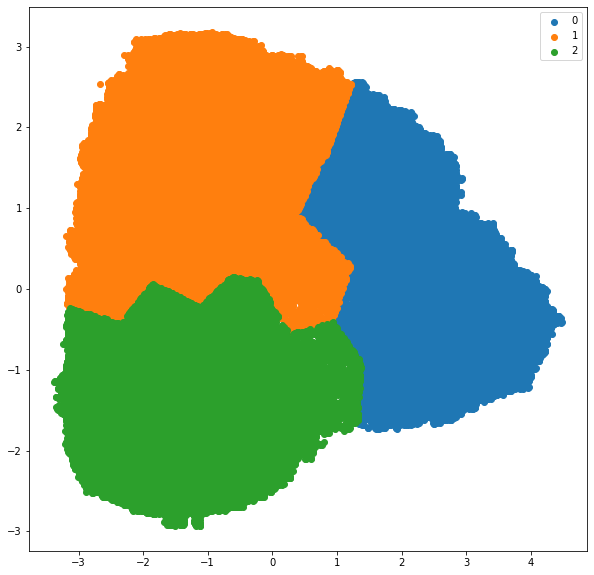

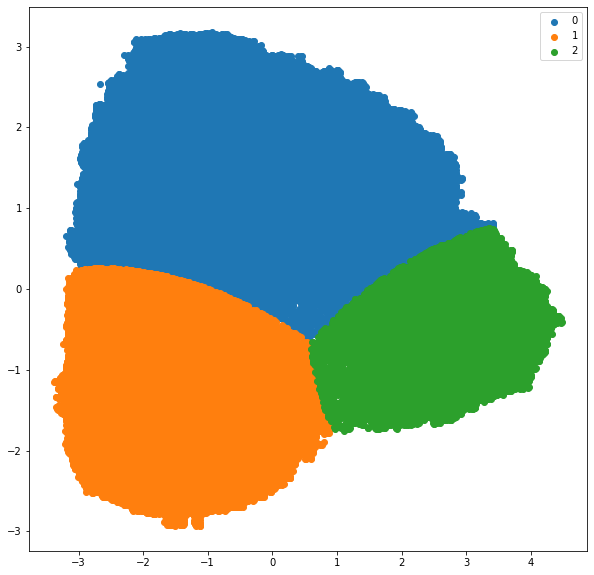

In [33]:
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from IPython.display import display, Image as ipimg
from PIL import Image as pilimg
from utils import render_multiple
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import extract_first_entries, generate_pixel_columns
import os, io

files = {
    './dataset/ambulance.ndjson' :4,
    './dataset/bed.ndjson' :4,
    './dataset/bench.ndjson' :4,
    './dataset/bread.ndjson' :4,
    './dataset/castle.ndjson' :4,
    './dataset/cell phone.ndjson' :4,
    './dataset/chair.ndjson' :4,
    './dataset/church.ndjson' :4,
    './dataset/coffee cup.ndjson' :4,
    './dataset/crown.ndjson' :4,
    './dataset/cruise ship.ndjson' :4,
    './dataset/cup.ndjson' :4,
    './dataset/diamond.ndjson' :4,
    './dataset/dishwasher.ndjson' :4,
    './dataset/dresser.ndjson' :4,
    './dataset/eye.ndjson' :4,
    './dataset/face.ndjson' :4,
    './dataset/fan.ndjson' :4,
    './dataset/fire hydrant.ndjson' :4,
    './dataset/fish.ndjson' :4,
    './dataset/hammer.ndjson' :4,
    './dataset/hat.ndjson' :4,
    './dataset/helicopter.ndjson' :4,
    './dataset/ice cream.ndjson' :4,
    './dataset/lantern.ndjson' :4,
    './dataset/passport.ndjson' :4,
    './dataset/pickup truck.ndjson' :4,
    './dataset/pillow.ndjson' :4,
    './dataset/power outlet.ndjson' :6,
    './dataset/sailboat.ndjson' :4,
    './dataset/sandwich.ndjson' :4,
    './dataset/snowman.ndjson' :4,
    './dataset/star.ndjson' :4,
    './dataset/strawberry.ndjson' :4,
    './dataset/suitcase.ndjson' :4,
    './dataset/table.ndjson' :4,
    './dataset/telephone.ndjson' :4,
    './dataset/traffic light.ndjson' :4,
    './dataset/watermelon.ndjson' :4,
    './dataset/wine glass.ndjson' :4,
}
if not os.path.exists('./clustering'):
    os.makedirs('./clustering')

for file, num_clusters in files.items():
    print(f'Processing {file}...')
    slash_idx = file.rindex('/')
    ext_idx = file.rindex('.ndjson')
    dir_name = './clustering/' + file[slash_idx + 1:ext_idx].replace(' ', '-')
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        print(f'Created directory "{dir_name}')
    else:
        print(f'Directory "{dir_name}" already exists.')

    df = extract_first_entries(file, recognized=True)
    print('Done loading')
    df = generate_pixel_columns(df, 32, 1, True)
    print('Done generating pixel columns')
    x = df.filter(regex=('pixel.+'))
    y = df['countrycode']

    pca = PCA(2)
    data = pca.fit_transform(x)
    print('Done transforming data')

    outlier_det = IsolationForest(random_state=42)
    outliers = outlier_det.fit_predict(data)
    print('Done with outlier detection')

    clsts = {
        'KMeans': KMeans(n_clusters = num_clusters, init = "k-means++"),
        'Birch': Birch(n_clusters=num_clusters),
        'Gaussian': GaussianMixture(
            n_components=num_clusters, covariance_type="full"
        )
    }

    df3 = pd.DataFrame(data)
    df3['outlier'] = np.array(map(lambda n: 1 if n < 0 else 0, outliers))
    df3['drawing'] = df['drawing']
    df3['countrycode'] = y
    df3 = df3[df3['outlier'] == 0]

    for typ, clst in clsts.items():
        inner_dir = f'{dir_name}/{typ}/'
        if not os.path.exists(inner_dir):
            os.makedirs(inner_dir)
            print(f'Created directory "{inner_dir}')
        pixels = df3.filter(regex='[01]')
        model = clst.fit_predict(pixels)
        print(f"Done fitting model {typ}")

        plt.figure(figsize=(10,10))
        clusters = np.unique(model)

        for cluster in clusters:
            drawings = df3[model == cluster]['drawing']
            img = pilimg.open(io.BytesIO(render_multiple(drawings if len(drawings) < 2000 else drawings.sample(2000))))
            img.save(inner_dir + 'cluster' + str(cluster) + '.png')
            plt.scatter(df3[model == cluster][0] , df3[model == cluster][1] , label = cluster)
        plt.legend()

        plt.savefig(inner_dir + 'plot.png')
        with open(inner_dir + 'stats.txt', 'w', encoding='utf8') as stats_file:
            stats_file.write(f'total entries: {len(df3)}\n')
            for cluster in clusters:
                stats_file.write(f'cluster{cluster} entries: {len(df3[model == cluster])}\n')
        print('Done saving images.')

In [ ]:
from matplotlib.colors import hsv_to_rgb
fig, ax = plt.subplots(figsize=(10,10))

data2 = pd.DataFrame(data)
data2['countrycode'] = y
counts = data2['countrycode'].value_counts()
counts = counts[(counts > 1000)]
groups = list(counts.to_dict().keys())
data2 = data2[data2['countrycode'].isin(groups)]
grouped = data2.groupby('countrycode')

colors = {key:hsv_to_rgb([((value+1)/len(groups)), .8, .75]) for value, key in enumerate(groups)}

for key, group in grouped:
    subgroup = group.sample(5) if len(group)>5 else group
    subgroup.plot(ax=ax, kind='scatter', x=0, y=1, label=key, color=[colors[key]])
plt.show()